# Descripción del proyecto
Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

## Introducción

## Inicialización

In [1]:
# cargar librerías

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from catboost import CatBoostClassifier


In [2]:
# cargar los datos

contract = pd.read_csv(r'C:\Users\OPERADOR\Desktop\cienciadedatos\final_provider\final_provider\contract.csv')
personal = pd.read_csv(r'C:\Users\OPERADOR\Desktop\cienciadedatos\final_provider\final_provider\personal.csv')
internet = pd.read_csv(r'C:\Users\OPERADOR\Desktop\cienciadedatos\final_provider\final_provider\internet.csv')
phone = pd.read_csv(r'C:\Users\OPERADOR\Desktop\cienciadedatos\final_provider\final_provider\phone.csv')

## Preparar los datos

## Contrato

In [3]:
# mostar el dataframe contract

contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
# cambiar nombre de columnas

columns_new ={
    "customerID": "user_id",
    "BeginDate": "begin_date",
    "EndDate": "end_date",
    "Type": "type",
    "PaperlessBilling": "paperless_billing",
    "PaymentMethod": "payment_method",
    "MonthlyCharges": "monthly_charges",
    "TotalCharges": "total_charges"}
contract.rename(columns = columns_new, inplace = True)
print(contract.columns)

Index(['user_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


In [6]:
# Cambiar los datos a datetime

contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')


In [7]:
# Crear una columna para los usuarios que han cancelado

def cancelled(score):
    if score == "No":
        return 0
    
    else:
        return 1


contract['canceled'] = contract['end_date'].apply(cancelled)

display(contract.sample(10))

,user_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,canceled
3816,4304-XUMGI,2015-12-01,No,Two year,Yes,Bank transfer (automatic),75.15,3822.45,0
5935,2931-FSOHN,2019-01-01,No,Month-to-month,Yes,Electronic check,59.90,788.35,0
4715,7508-DQAKK,2014-10-01,No,Two year,Yes,Credit card (automatic),86.40,5442.05,0
6214,6725-TPKJO,2016-06-01,No,Two year,No,Mailed check,20.05,845.25,0
3559,5171-EPLKN,2017-11-01,No,Two year,No,Credit card (automatic),19.85,470,0
282,2080-SRCDE,2020-01-01,No,Month-to-month,No,Mailed check,25.40,25.4,0
6560,9801-NOSHQ,2018-03-01,No,One year,No,Mailed check,19.80,465.45,0
3783,1469-LBJQJ,2014-08-01,No,Month-to-month,Yes,Electronic check,105.20,6936.85,0
690,8262-COGGB,2020-01-01,No,Month-to-month,Yes,Mailed check,20.45,20.45,0
5034,9758-MFWGD,2016-02-01,No,One year,No,Bank transfer (automatic),29.90,1388.75,0


In [8]:
contract.dtypes

user_id                      object
begin_date           datetime64[ns]
end_date                     object
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges                object
canceled                      int64
dtype: object

In [9]:
# Convertiré las columnas con opciones binarias en 0 y 1

binary_cols = ['paperless_billing']

# Definir valores
mapping = {'Yes': 1,
           'No': 0
           }

# Definir funcion para cambiar valores
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Llamar a la función
contract = binarise_values(contract, binary_cols, mapping)

display(contract.head(10))

,user_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,canceled
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,1
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,99.65,820.5,1
6,1452-KIOVK,2018-04-01,No,Month-to-month,1,Credit card (automatic),89.10,1949.4,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,0,Mailed check,29.75,301.9,0
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,104.80,3046.05,1
9,6388-TABGU,2014-12-01,No,One year,0,Bank transfer (automatic),56.15,3487.95,0


In [10]:
# Codificar las columnas para facilitarle los datos al modelo

le = LabelEncoder()
contract['type'] = le.fit_transform(contract['type'])
contract['payment_method'] = le.fit_transform(contract['payment_method'])

display(contract.head(10))

,user_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,canceled
0,7590-VHVEG,2020-01-01,No,0,1,2,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,1,0,3,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0,1,3,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,1,0,0,42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,0,1,2,70.70,151.65,1
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,0,1,2,99.65,820.5,1
6,1452-KIOVK,2018-04-01,No,0,1,1,89.10,1949.4,0
7,6713-OKOMC,2019-04-01,No,0,0,3,29.75,301.9,0
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,0,1,2,104.80,3046.05,1
9,6388-TABGU,2014-12-01,No,1,0,0,56.15,3487.95,0


In [11]:
contract['type'].unique()

array([0, 1, 2])

In [12]:
contract['paperless_billing'].unique()

array([1, 0], dtype=int64)

In [13]:
contract['payment_method'].unique()

array([2, 3, 0, 1])

In [14]:
# Verificar si hay valores no numéricos en las columnas


print(contract[['monthly_charges', 'total_charges']].apply(pd.to_numeric, errors='coerce').isnull().sum())

monthly_charges     0
total_charges      11
dtype: int64


In [15]:
# Convertir las columnas a numéricas, convirtiendo cualquier valor inválido a NaN

contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')


In [16]:
# Rellenar los valores ausentes con la mediana

contract.fillna({'total_charges': contract['total_charges'].median()}, inplace=True)


<Axes: >

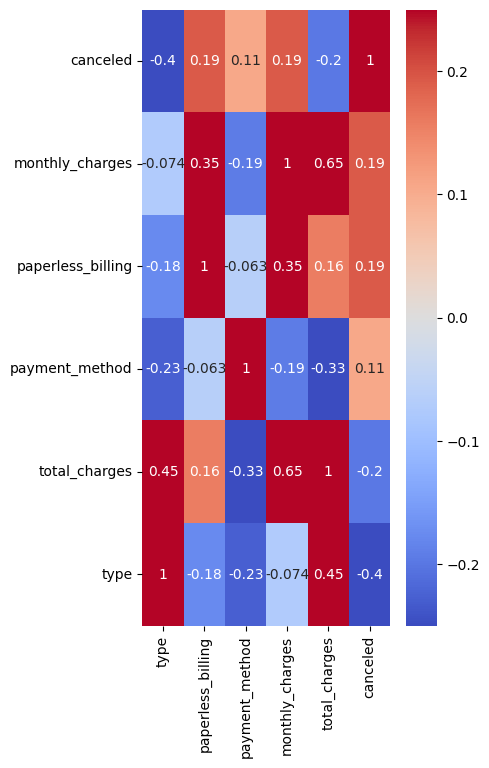

In [17]:
# Veamos las correlaciones más importantes conforme a la variable objetivo

contract_corr = contract[['type', 'paperless_billing', 
                          'payment_method', 'monthly_charges', 'total_charges', 'canceled']]

fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = contract_corr.corr().sort_values(by='canceled',ascending=False)

sns.heatmap(corr_matrix,cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

## Personal

In [18]:
# mostar el dataframe personal

display(personal.head(10))

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [19]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [20]:
# cambiar nombre de columnas

columns_new ={
    "customerID": "user_id",
    "SeniorCitizen": "senior_citizen",
    "Partner": "partner",
    "Dependents": "dependents"}
personal.rename(columns = columns_new, inplace = True)
print(personal.columns)

Index(['user_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


In [21]:
# codificar las variables binarias

personal['gender'] = le.fit_transform(personal['gender'])
personal['partner'] = le.fit_transform(personal['partner'])
personal['dependents'] = le.fit_transform(personal['dependents'])

display(personal.head(10))

,user_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0
5,9305-CDSKC,0,0,0,0
6,1452-KIOVK,1,0,0,1
7,6713-OKOMC,0,0,0,0
8,7892-POOKP,0,0,1,0
9,6388-TABGU,1,0,0,1


In [22]:
personal['senior_citizen'].unique()

array([0, 1], dtype=int64)

## Internet

In [23]:
# mostar el dataframe internet

internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [24]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [25]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [26]:
# cambiar nombre de columnas

columns_new ={
    "customerID": "user_id",
    "InternetService": "internet_service",
    "OnlineSecurity": "online_security",
    "OnlineBackup": "online_backup",
    "DeviceProtection": "device_protection",
    "TechSupport": "tech_support",
    "StreamingTV": "streaming_tv",
    "StreamingMovies": "streaming_movies"}
internet.rename(columns = columns_new, inplace = True)
print(internet.columns)

Index(['user_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


In [27]:
# codificar las variables binarias

internet['internet_service'] = le.fit_transform(internet['internet_service'])
internet['online_security'] = le.fit_transform(internet['online_security'])
internet['online_backup'] = le.fit_transform(internet['online_backup'])
internet['device_protection'] = le.fit_transform(internet['device_protection'])
internet['tech_support'] = le.fit_transform(internet['tech_support'])
internet['streaming_tv'] = le.fit_transform(internet['streaming_tv'])
internet['streaming_movies'] = le.fit_transform(internet['streaming_movies'])

display(internet.head(10))

,user_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,0,0,1,0,0,0,0
1,5575-GNVDE,0,1,0,1,0,0,0
2,3668-QPYBK,0,1,1,0,0,0,0
3,7795-CFOCW,0,1,0,1,1,0,0
4,9237-HQITU,1,0,0,0,0,0,0
5,9305-CDSKC,1,0,0,1,0,1,1
6,1452-KIOVK,1,0,1,0,0,1,0
7,6713-OKOMC,0,1,0,0,0,0,0
8,7892-POOKP,1,0,0,1,1,1,1
9,6388-TABGU,0,1,1,0,0,0,0


## Teléfono

In [28]:
# mostar el dataframe phone

print(phone)

      customerID MultipleLines
0     5575-GNVDE            No
1     3668-QPYBK            No
2     9237-HQITU            No
3     9305-CDSKC           Yes
4     1452-KIOVK           Yes
...          ...           ...
6356  2569-WGERO            No
6357  6840-RESVB           Yes
6358  2234-XADUH           Yes
6359  8361-LTMKD           Yes
6360  3186-AJIEK            No

[6361 rows x 2 columns]


In [29]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [30]:
# cambiar nombre de columnas

columns_new ={
    "customerID": "user_id",
    "MultipleLines": "multiple_lines"}

phone.rename(columns = columns_new, inplace = True)
print(phone.columns)

Index(['user_id', 'multiple_lines'], dtype='object')


In [31]:
# codificar las variables binarias

phone['multiple_lines'] = le.fit_transform(phone['multiple_lines'])

display(phone.head(10))

,user_id,multiple_lines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1
5,7892-POOKP,1
6,6388-TABGU,0
7,9763-GRSKD,0
8,7469-LKBCI,0
9,8091-TTVAX,1


## Dataframe completo

In [32]:
# Merge del dataframe contract con personal
df_merge = pd.merge(contract, personal, on='user_id', how='outer')

# Merge del resultado con internet
df_merge = pd.merge(df_merge, internet, on='user_id', how='outer')

# Merge del resultado con phone
df_merge = pd.merge(df_merge, phone, on='user_id', how='outer')

print(df_merge)

         user_id begin_date             end_date  type  paperless_billing  \
0     0002-ORFBO 2019-05-01                   No     1                  1   
1     0003-MKNFE 2019-05-01                   No     0                  0   
2     0004-TLHLJ 2019-09-01  2020-01-01 00:00:00     0                  1   
3     0011-IGKFF 2018-12-01  2020-01-01 00:00:00     0                  1   
4     0013-EXCHZ 2019-09-01  2019-12-01 00:00:00     0                  1   
...          ...        ...                  ...   ...                ...   
7038  9987-LUTYD 2019-01-01                   No     1                  0   
7039  9992-RRAMN 2018-02-01  2019-12-01 00:00:00     0                  1   
7040  9992-UJOEL 2019-12-01                   No     0                  1   
7041  9993-LHIEB 2014-07-01                   No     2                  0   
7042  9995-HOTOH 2014-11-01                   No     2                  0   

      payment_method  monthly_charges  total_charges  canceled  gender  ...

In [33]:
df_merge.isna().sum()

user_id                 0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
canceled                0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [34]:
# Veo que end_date solo tiene 4 meses consecutivos por lo que no podré sacar una comparativa con otros años para el modelo
# Usaré la columna de cancelado para la variable objetivo.
df_merge['end_date'].unique()



array(['No', '2020-01-01 00:00:00', '2019-12-01 00:00:00',
       '2019-11-01 00:00:00', '2019-10-01 00:00:00'], dtype=object)

In [35]:
# los valores ausentes son de los espacios de clientes que no tienen servicio de internet, los rellenaré como 0 por lo mismo.

df_merge.fillna(0, inplace=True)

In [36]:
# Verificar los datos

df_merge.isna().sum()

user_id              0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
canceled             0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

In [40]:
# Separo las características y la variable objetivo

features = df_merge.drop(columns=['canceled', 'end_date', 'user_id', 'begin_date'])
target = df_merge['canceled']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [48]:
# comprueba el desequilibrio de clases con value_counts()

y_train.value_counts()

canceled
0    4138
1    1496
Name: count, dtype: int64

In [49]:
# comprueba el desequilibrio de clases con value_counts()

y_test.value_counts()

canceled
0    1036
1     373
Name: count, dtype: int64

In [41]:
# Regresión logística (Prueba de cordura)

# Inicializar el modelo
log_reg = LogisticRegression()

# Entrenar el modelo
log_reg.fit(x_train, y_train)

# Hacer predicciones
y_pred = log_reg.predict(x_test)

# Evaluar el rendimiento
print(classification_report(y_test, y_pred))
print("AUC-ROC:",roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.66      0.52      0.58       373

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409

AUC-ROC: 0.7127563220056516


C:\Users\OPERADOR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
# Random forest

# Inicializar el modelo
rndm_f = RandomForestClassifier()

# Entrenar el modelo
rndm_f.fit(x_train, y_train)

# Hacer predicciones
y_pred = rndm_f.predict(x_test)

# Evaluar el rendimiento
print(classification_report(y_test, y_pred))
print("AUC-ROC:",roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.65      0.46      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409

AUC-ROC: 0.6870193153705219


In [43]:
# Gradient boosting

# Inicializar el modelo
g_bst = GradientBoostingClassifier()

# Entrenar el modelo
g_bst.fit(x_train, y_train)

# Hacer predicciones
y_pred = g_bst.predict(x_test)

# Evaluar el rendimiento
print(classification_report(y_test, y_pred))
print("AUC-ROC:",roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.53      0.60       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409

AUC-ROC: 0.7202635419793595


In [44]:
# Ada boost

# Inicializar el modelo
a_bst = AdaBoostClassifier()

# Entrenar el modelo
a_bst.fit(x_train, y_train)

# Hacer predicciones
y_pred = a_bst.predict(x_test)

# Evaluar el rendimiento
print(classification_report(y_test, y_pred))
print("AUC-ROC:",roc_auc_score(y_test, y_pred))

C:\Users\OPERADOR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.65      0.52      0.58       373

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

AUC-ROC: 0.7080374610535469


Haré las visualizaciones de datos para responder las preguntas aclaratorias.

In [45]:
serv_int= df_merge[df_merge['internet_service'] == 1]

serv_int['canceled'].value_counts()

canceled
0    1799
1    1297
Name: count, dtype: int64

In [46]:
serv_int= df_merge[df_merge['internet_service'] == 0]

serv_int['canceled'].value_counts()

canceled
0    3375
1     572
Name: count, dtype: int64

In [50]:
contract['end_date'].value_counts()

end_date
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

In [53]:
df_merge.groupby('canceled').agg({
    'internet_service': 'value_counts',
    'online_security': 'value_counts',
    'online_backup': 'value_counts',
    'device_protection': 'value_counts',
    'tech_support': 'value_counts',
    'streaming_tv': 'value_counts',
    'streaming_movies': 'value_counts'
})

internet_service  online_security  online_backup  \
canceled                                                         
0        0.0              3375             3450           3268   
         1.0              1799             1724           1906   
1        1.0              1297              295            523   
         0.0               572             1574           1346   

              device_protection  tech_support  streaming_tv  streaming_movies  
canceled                                                                       
0        0.0               3297          3440          3281              3260  
         1.0               1877          1734          1893              1914  
1        1.0                545           310           814               818  
         0.0               1324          1559          1055              1051

# Preguntas aclaratorias

¿Qué variable tendrá más correlación con que un cliente cancele?

El tipo de contraro es la variable que mayor correlación tiene.

¿Habrá alguna fecha en qué haya más cancelaciones?

En Noviembre fue cuando más cancelaciones hubo, pero la diferencia con las otras fechas es muy poca. Por lo tanto no creo que sea algo relevante.

¿Cancelarán más los usuarios con 1 o 2 servicios?

Cancelan más los que cuentan con internet.

¿El tener 1 o más servicios extras en el internet hace a un cliente menos dispuesto a cancelar?

Cuando un cliente no tiene servicios extras de internet tiende más a cancelar.
